### Performing Variable Discretization

Discretization is the process of transforming continuous variables into discrete features by creating a set of contiguous intervals, also called bins, which span the range of the variable values. Subsequently, these intervals are treated as categorical data.

Many machine learning models, such as decision trees and Naïve Bayes, work better with discrete attributes. In fact, decision tree-based models make decisions based on discrete partitions over the attributes. During induction, a decision tree evaluates all possible feature values to find the best cut-point. Therefore, the more values the feature has, the longer the induction time of the tree is. In this sense, discretization can reduce the time it takes to train the models

This chapter contains the following recipes:
			
- Performing equal-width discretization
- Implementing equal-frequency discretization
- Discretizing the variable into arbitrary intervals
- Performing discretization with k-means clustering
- Implementing feature binarization
- Using decision trees for discretization

### Performing equal-width discretization

Equal-width discretization consists of dividing the range of observed values for a variable into k equally sized intervals, where k is supplied by the user


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Next, we will divide the continuous HouseAge variable into 10 intervals using pandas and the formula described at the beginning of the recipe

In [64]:
main_value = int(X_train['HouseAge'].min())
max_value = int(X_train['HouseAge'].max())

width= int((max_value - main_value) / 10) 
width

5

Now we need to define the interval limits and store them in a list:

In [65]:
interval_limits = [i for i in range(main_value, max_value, width)]
interval_limits

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51]

In [66]:
interval_limits[0] = -np.inf
interval_limits[-1] = np.inf
interval_limits

[-inf, 6, 11, 16, 21, 26, 31, 36, 41, 46, inf]

In [67]:
train_t = X_train.copy()
test_t = X_test.copy()

In [68]:
train_t['HouseAge_disc'] = pd.cut(x=X_train['HouseAge'], bins=interval_limits, include_lowest=True)
test_t['HouseAge_disc'] = pd.cut(x=X_test['HouseAge'], bins=interval_limits, include_lowest=True)

In [69]:
print(train_t[['HouseAge','HouseAge_disc']].head())

      HouseAge HouseAge_disc
1989      52.0   (46.0, inf]
256       43.0  (41.0, 46.0]
7887      17.0  (16.0, 21.0]
4581      17.0  (16.0, 21.0]
1993      50.0   (46.0, inf]


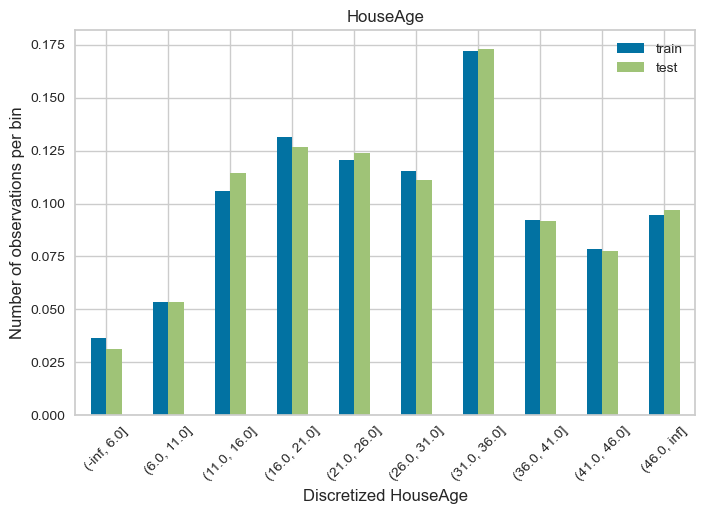

In [70]:
t1 = train_t['HouseAge_disc'].value_counts(normalize=True, sort=False)
t2 = test_t['HouseAge_disc'].value_counts(normalize=True, sort=False)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar(figsize=(8, 5))
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')
plt.xlabel('Discretized HouseAge')
plt.title('HouseAge')
plt.show()


With feature-engine, we can perform equal-width discretization in fewer lines of code and for many variables at a time

In [71]:
from feature_engine.discretisation import EqualWidthDiscretiser

variables = ['MedInc','HouseAge','AveRooms']
disc = EqualWidthDiscretiser(bins=8, variables=variables)

disc.fit(X_train)

EqualWidthDiscretiser(bins=8, variables=['MedInc', 'HouseAge', 'AveRooms'])

In [72]:
disc.binner_dict_

{'MedInc': [-inf,
  2.312425,
  4.12495,
  5.937475,
  7.75,
  9.562525,
  11.37505,
  13.187574999999999,
  inf],
 'HouseAge': [-inf, 7.375, 13.75, 20.125, 26.5, 32.875, 39.25, 45.625, inf],
 'AveRooms': [-inf,
  17.307051282051283,
  33.76794871794872,
  50.228846153846156,
  66.68974358974359,
  83.15064102564102,
  99.61153846153846,
  116.0724358974359,
  inf]}

In [73]:
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

train_t.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
1989,0,7,0,0.700000,193.0,4.825000,36.73,-119.79
256,0,6,0,1.184116,836.0,3.018051,37.77,-122.21
7887,3,2,0,1.087912,1387.0,3.810440,33.87,-118.04
4581,0,2,0,1.196000,3051.0,3.051000,34.06,-118.28
1993,0,7,0,1.161677,606.0,3.628743,36.73,-119.81


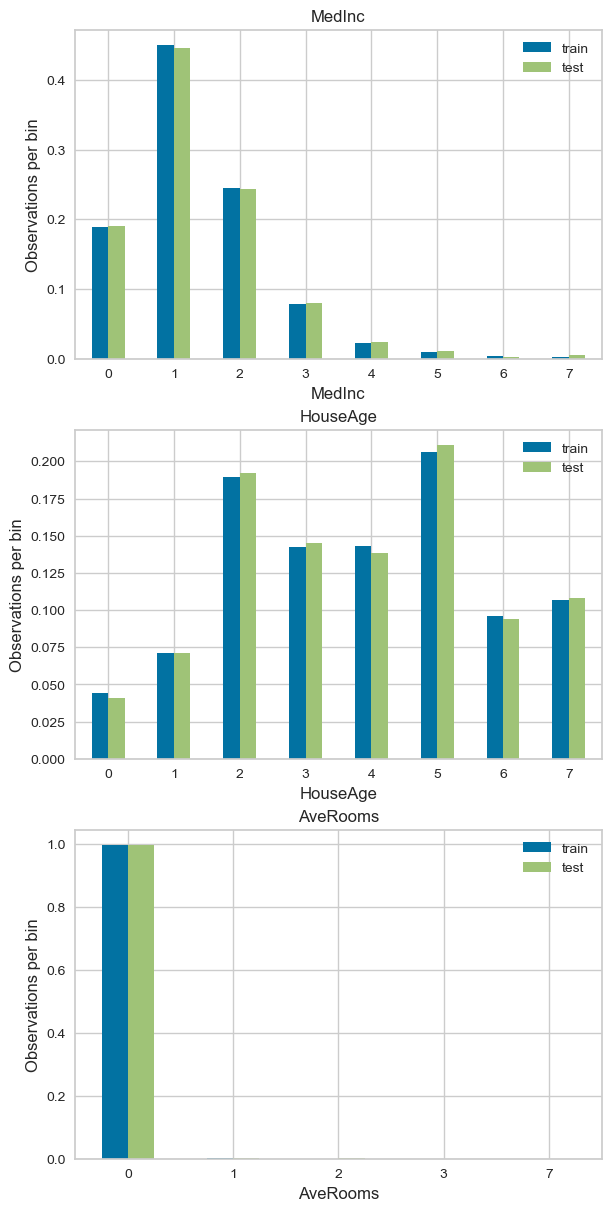

In [74]:
plt.figure(figsize=(6, 12), constrained_layout=True)
for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    var = variables[i]
    t1 = train_t[var].value_counts(normalize=True, sort=False)
    t2 = test_t[var].value_counts(normalize=True, sort=False)
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train','test']
    tmp.sort_index(inplace=True)
    tmp.plot.bar(ax=ax)
    plt.xticks(rotation=0)
    plt.ylabel('Observations per bin')
    ax.set_title(var)
plt.show()

### Implementing equal-frequency discretization

Equal-width discretization is intuitive and easy to compute. However, if the variables are skewed, then there will be many empty bins or bins with only a few values, while most observations will be allocated to a few intervals. This could result in a loss of information.

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

train_t = X_train.copy()
test_t = X_test.copy()


We'll use pandas qcut()to obtain a discretized copy of the HouseAge variable, which we will store as a new column in the training set, and the limits of eight equal-frequency intervals

In [76]:
train_t['House_disc'], interval_limits = pd.qcut(x=X_train['HouseAge'], q=8, labels=None, retbins=True)
interval_limits

array([ 1., 14., 18., 24., 29., 34., 37., 44., 52.])

In [77]:
print(train_t[['HouseAge', 'House_disc']].head(5))

      HouseAge    House_disc
1989      52.0  (44.0, 52.0]
256       43.0  (37.0, 44.0]
7887      17.0  (14.0, 18.0]
4581      17.0  (14.0, 18.0]
1993      50.0  (44.0, 52.0]


Now, let's discretize HouseAge in the test set, using pandas cut() with the interval limits determined in step 5

In [78]:
test_t['House_disc'] = pd.cut(x=X_test['HouseAge'], bins=interval_limits, include_lowest=True)

Let's make a bar plot with the proportion of observations per interval in the train and test sets

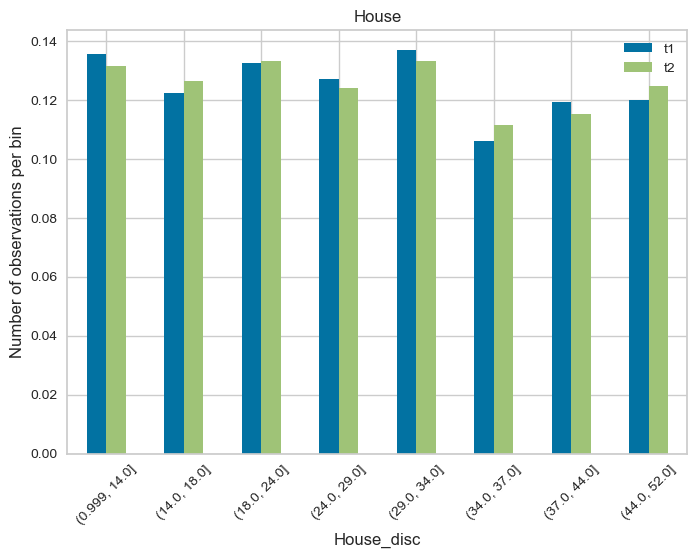

In [79]:
t1 = train_t['House_disc'].value_counts(normalize=True)
t2 = test_t['House_disc'].value_counts(normalize=True)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ["t1","t2"]
tmp.sort_index(inplace=True)
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')
plt.title('House')
plt.show()

With feature-engine, we can apply equal-frequency discretization to multiple variables

In [80]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

variables = ['MedInc','HouseAge','AveRooms']
disc = EqualFrequencyDiscretiser(q=8, variables=variables, return_boundaries=True)

In [81]:
disc.fit(X_train)

EqualFrequencyDiscretiser(q=8, return_boundaries=True,
                          variables=['MedInc', 'HouseAge', 'AveRooms'])

In [82]:
disc.binner_dict_

{'MedInc': [-inf,
  2.034575,
  2.5705999999999998,
  3.0544875,
  3.5391,
  4.0625,
  4.7361,
  5.82005,
  inf],
 'HouseAge': [-inf, 14.0, 18.0, 24.0, 29.0, 34.0, 37.0, 44.0, inf],
 'AveRooms': [-inf,
  3.9327875134642474,
  4.452248826108891,
  4.863974466763416,
  5.2293176328502415,
  5.59931032069662,
  6.0476190476190474,
  6.716898489638216,
  inf]}

**NOTE**: feature-engine will automatically extend the limits of the lower and upper intervals to infinite to accommodate potential outliers in future data.

In [83]:
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

Let's make bar plots with the fraction of observations per interval to better understand the effect of equal-frequency discretization

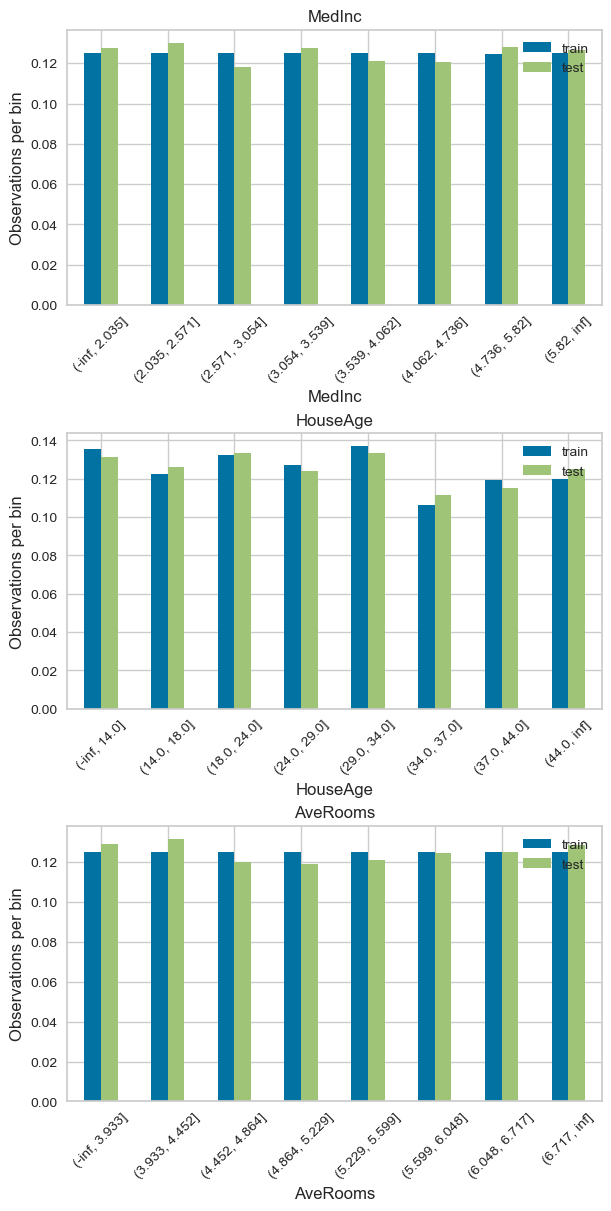

In [84]:
plt.figure(figsize=(6, 12), constrained_layout=True)
for i in range(3):
    # location of plot in figure
    ax = plt.subplot(3, 1, i + 1)
    var = variables[i]
    t1 = train_t[var].value_counts(normalize=True)
    t2 = test_t[var].value_counts(normalize=True)

    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']
    tmp.sort_index(inplace=True)
    tmp.plot.bar(ax=ax)
    plt.xticks(rotation=45)
    plt.ylabel('Observations per bin')
    ax.set_title(var)
plt.show()

### Discretizing the variable into arbitrary intervals

In various industries, it is common to group variable values into segments that make sense for the business. For example, we might want to group the variable age in intervals representing children, young adults, middle-aged people, and retirees.

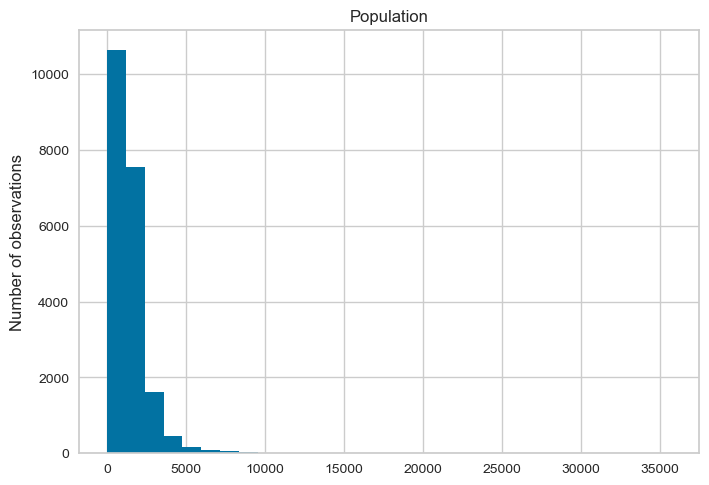

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

X['Population'].hist(bins=30)
plt.title('Population')
plt.ylabel('Number of observations')
plt.show()

Let's create a list with arbitrary interval limits, setting the upper limit to infinity to accommodate bigger values:

In [86]:
intervals = [0, 200, 500, 1000, 2000, np.inf]

# Let's create a list with the interval limits as strings
labels = ["0-200", "200-500","500-1000","1000-2000",">2000"]

X_t = X.copy()
X_t["Population_limits"] = pd.cut(X["Population"], bins=intervals, labels=None, include_lowest=True)


Now, let's discretize Population into pre-defined intervals and name the intervals with the labels that we defined in step 5 for comparison

In [87]:
X_t["Population_range"] = pd.cut(X["Population"], bins=intervals, labels=labels, include_lowest=True)

Let's inspect the first five rows of the original and discretized variables:

In [88]:
X_t[["Population","Population_range", "Population_limits"]].head()

,Population,Population_range,Population_limits
0,322.0,200-500,"(200.0, 500.0]"
1,2401.0,>2000,"(2000.0, inf]"
2,496.0,200-500,"(200.0, 500.0]"
3,558.0,500-1000,"(500.0, 1000.0]"
4,565.0,500-1000,"(500.0, 1000.0]"


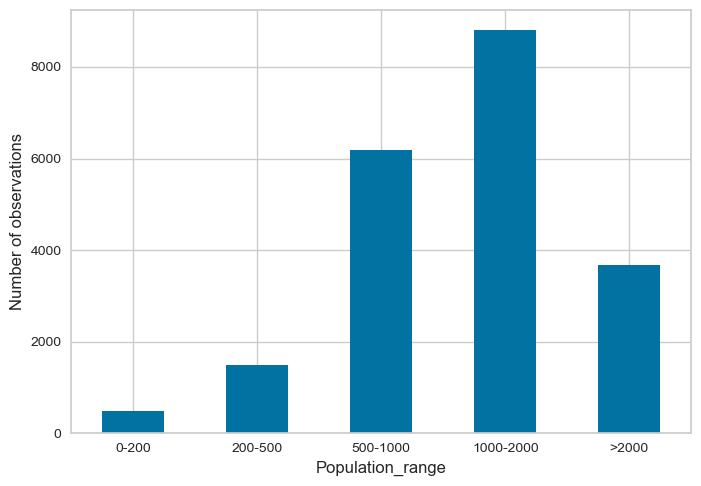

In [89]:
X_t['Population_range'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations')
plt.show()

To wrap up the recipe, let's discretize multiple variables utilizing feature-engine:

In [90]:
from feature_engine.discretisation import ArbitraryDiscretiser

Let's create a dictionary with the variables as keys and the interval limits as values

In [91]:
intervals = {
        "Population": [0, 200, 500, 1000, 2000, np.inf],
        "MedInc": [0, 2, 4, 6, np.inf]
    }

In [92]:
disc = ArbitraryDiscretiser(binning_dict=intervals, return_boundaries=True)
X_t = disc.fit_transform(X)

In [93]:
X_t.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,"(6.0, inf]",41.0,6.984127,1.023810,"(200.0, 500.0]",2.555556,37.88,-122.23
1,"(6.0, inf]",21.0,6.238137,0.971880,"(2000.0, inf]",2.109842,37.86,-122.22
2,"(6.0, inf]",52.0,8.288136,1.073446,"(200.0, 500.0]",2.802260,37.85,-122.24
3,"(4.0, 6.0]",52.0,5.817352,1.073059,"(500.0, 1000.0]",2.547945,37.85,-122.25
4,"(2.0, 4.0]",52.0,6.281853,1.081081,"(500.0, 1000.0]",2.181467,37.85,-122.25


### Performing discretization with k-means clustering

The aim of a discretization procedure is to find a set of cut points that partition a variable into a small number of intervals that have good class coherence. To create partitions that group similar observations, we can use clustering algorithms such as k-means

In [94]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from yellowbrick.cluster import KElbowVisualizer

In [95]:
X,y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

variables = ['MedInc','HouseAge','AveRooms']

k_means = KMeans(random_state=10)

Now, using Yellowbrick's visualizer and the elbow method, let's find the optimal number of clusters for each variable:

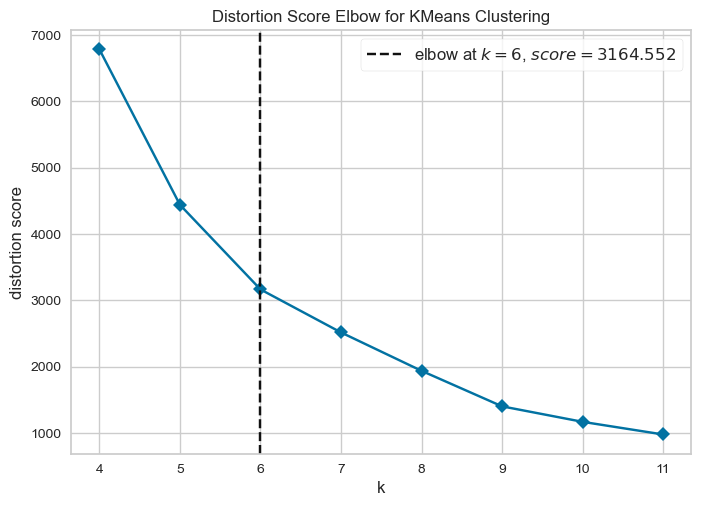

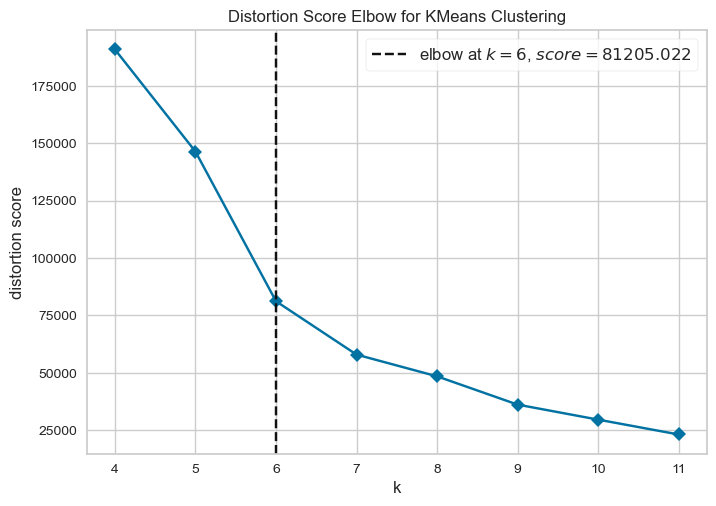

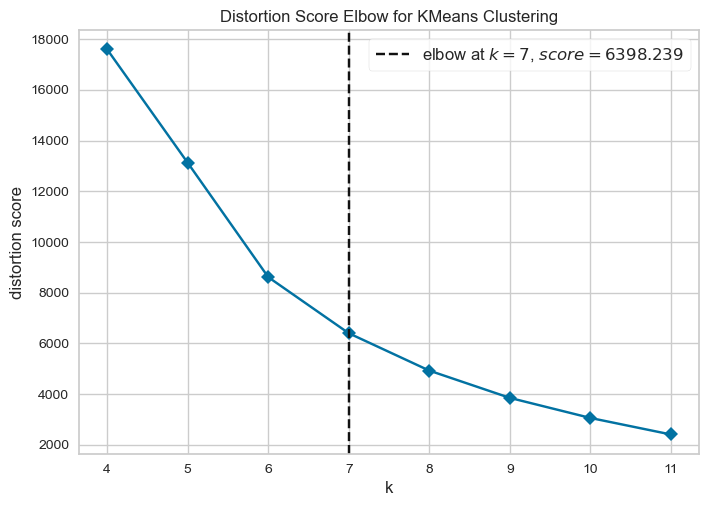

In [96]:
for var in variables:
    visualizer = KElbowVisualizer(k_means, k=(4, 12), metric='distortion', timings=False)
    visualizer.fit(X_train[var].to_frame())
    visualizer.show()


In the following plots, we see that the optimal number of clusters is six for the first two variables and seven for the third

Let's set up a discretizer that uses k-means clustering to create six partitions and returns the clusters as one-hot-encoded variables:

In [97]:
disc = KBinsDiscretizer(
    n_bins=6,
    encode="onehot-dense",
    strategy='kmeans',
    subsample=None
).set_output(transform='pandas')

disc.fit(X_train[variables])

KBinsDiscretizer(encode='onehot-dense', n_bins=6, strategy='kmeans',
                 subsample=None)

In [98]:
disc.bin_edges_

array([array([ 0.4999    ,  2.49587954,  3.66599029,  4.95730115,  6.67700141,
               9.67326677, 15.0001    ])                                      ,
       array([ 1.        , 11.7038878 , 19.88430419, 27.81472503, 35.39424098,
              43.90930314, 52.        ])                                      ,
       array([  0.84615385,   4.90208858,   6.72106111,  15.36396902,
               37.66406307,  92.4473438 , 132.53333333])             ],
      dtype=object)

In [99]:
train_features = disc.transform(X_train[variables])
test_features = disc.transform(X_test[variables])

In [100]:
train_features.head()

,MedInc_0.0,MedInc_1.0,MedInc_2.0,MedInc_3.0,MedInc_4.0,MedInc_5.0,HouseAge_0.0,HouseAge_1.0,HouseAge_2.0,HouseAge_3.0,HouseAge_4.0,HouseAge_5.0,AveRooms_0.0,AveRooms_1.0,AveRooms_2.0,AveRooms_3.0,AveRooms_4.0,AveRooms_5.0
1989,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
256,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7887,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4581,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1993,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


### Implementing feature binarization

Some datasets contain sparse variables. Sparse variables are those where the majority of the values are 0. The classical example of sparse variables are those derived from text data through the bag-of-words model, where each variable is a word and each value represents the number of times the word appears in a certain document. Given that a document contains a limited number of words, whereas the feature space contains the words that appear across all documents, most documents, that is, most rows, will show a value of 0 for most columns. However, words are not the sole example

If we think about house details data, the number of saunas variable will also be 0 for most houses. In summary, some variables have very skewed distributions, where most observations show the same value, usually 0, and only a few observations show different, usually higher, values.

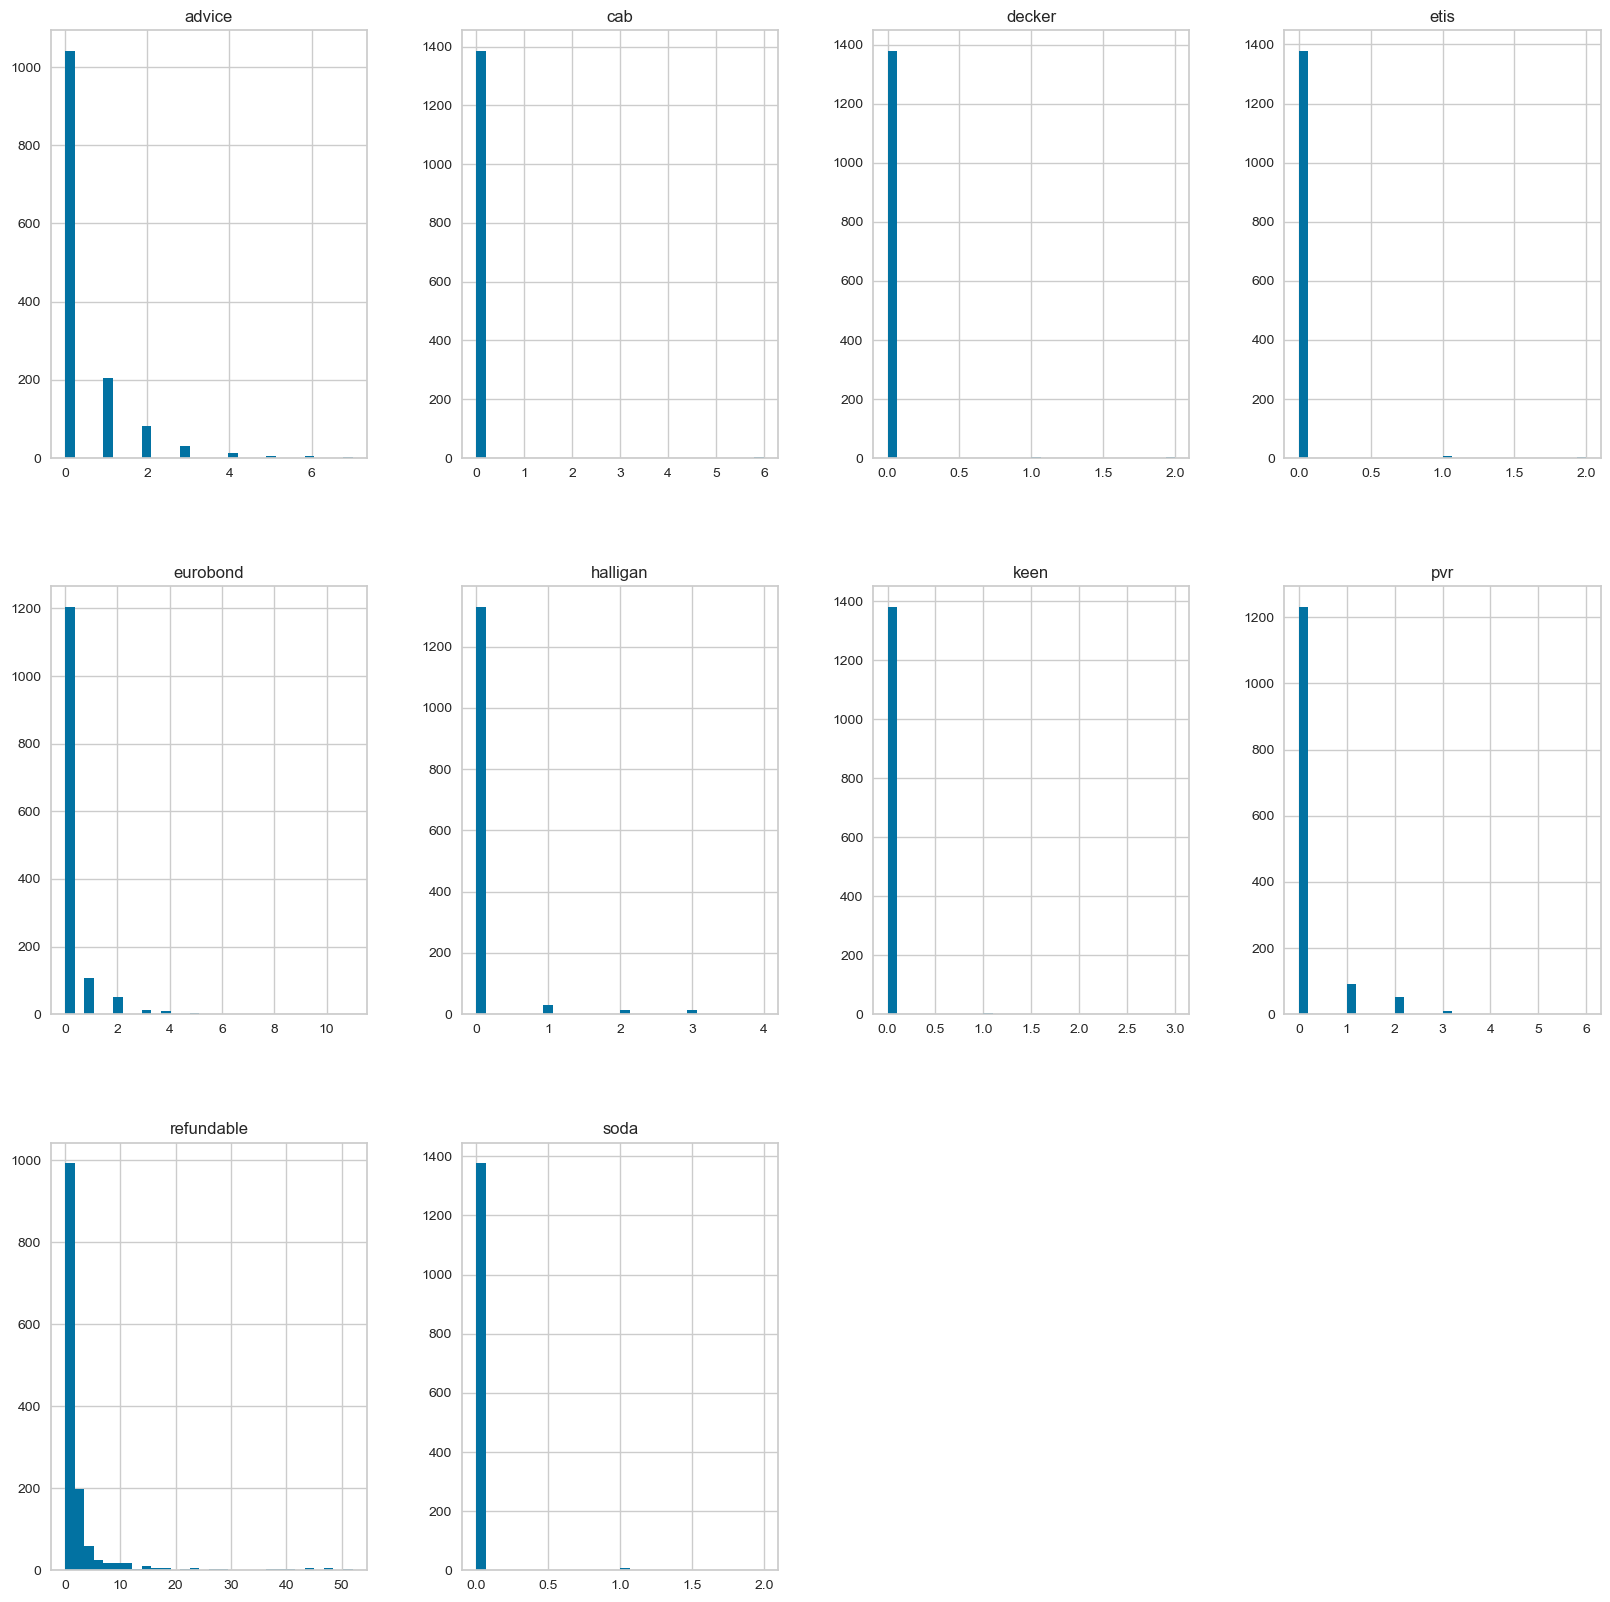

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer

data = pd.read_csv('../source/ch04-discretization/bag_of_words.csv')
data.hist(bins=30, figsize=(20, 20), layout=(3,4))
plt.show()

Let's set up binarizer to clip all values greater than 1 to 1 and return DataFrames as a result:

In [102]:
binarizer = Binarizer(threshold=0).set_output(transform='pandas')

data_t = binarizer.fit_transform(data)

Let's create a bar plot with the number of observations per bin per variable:

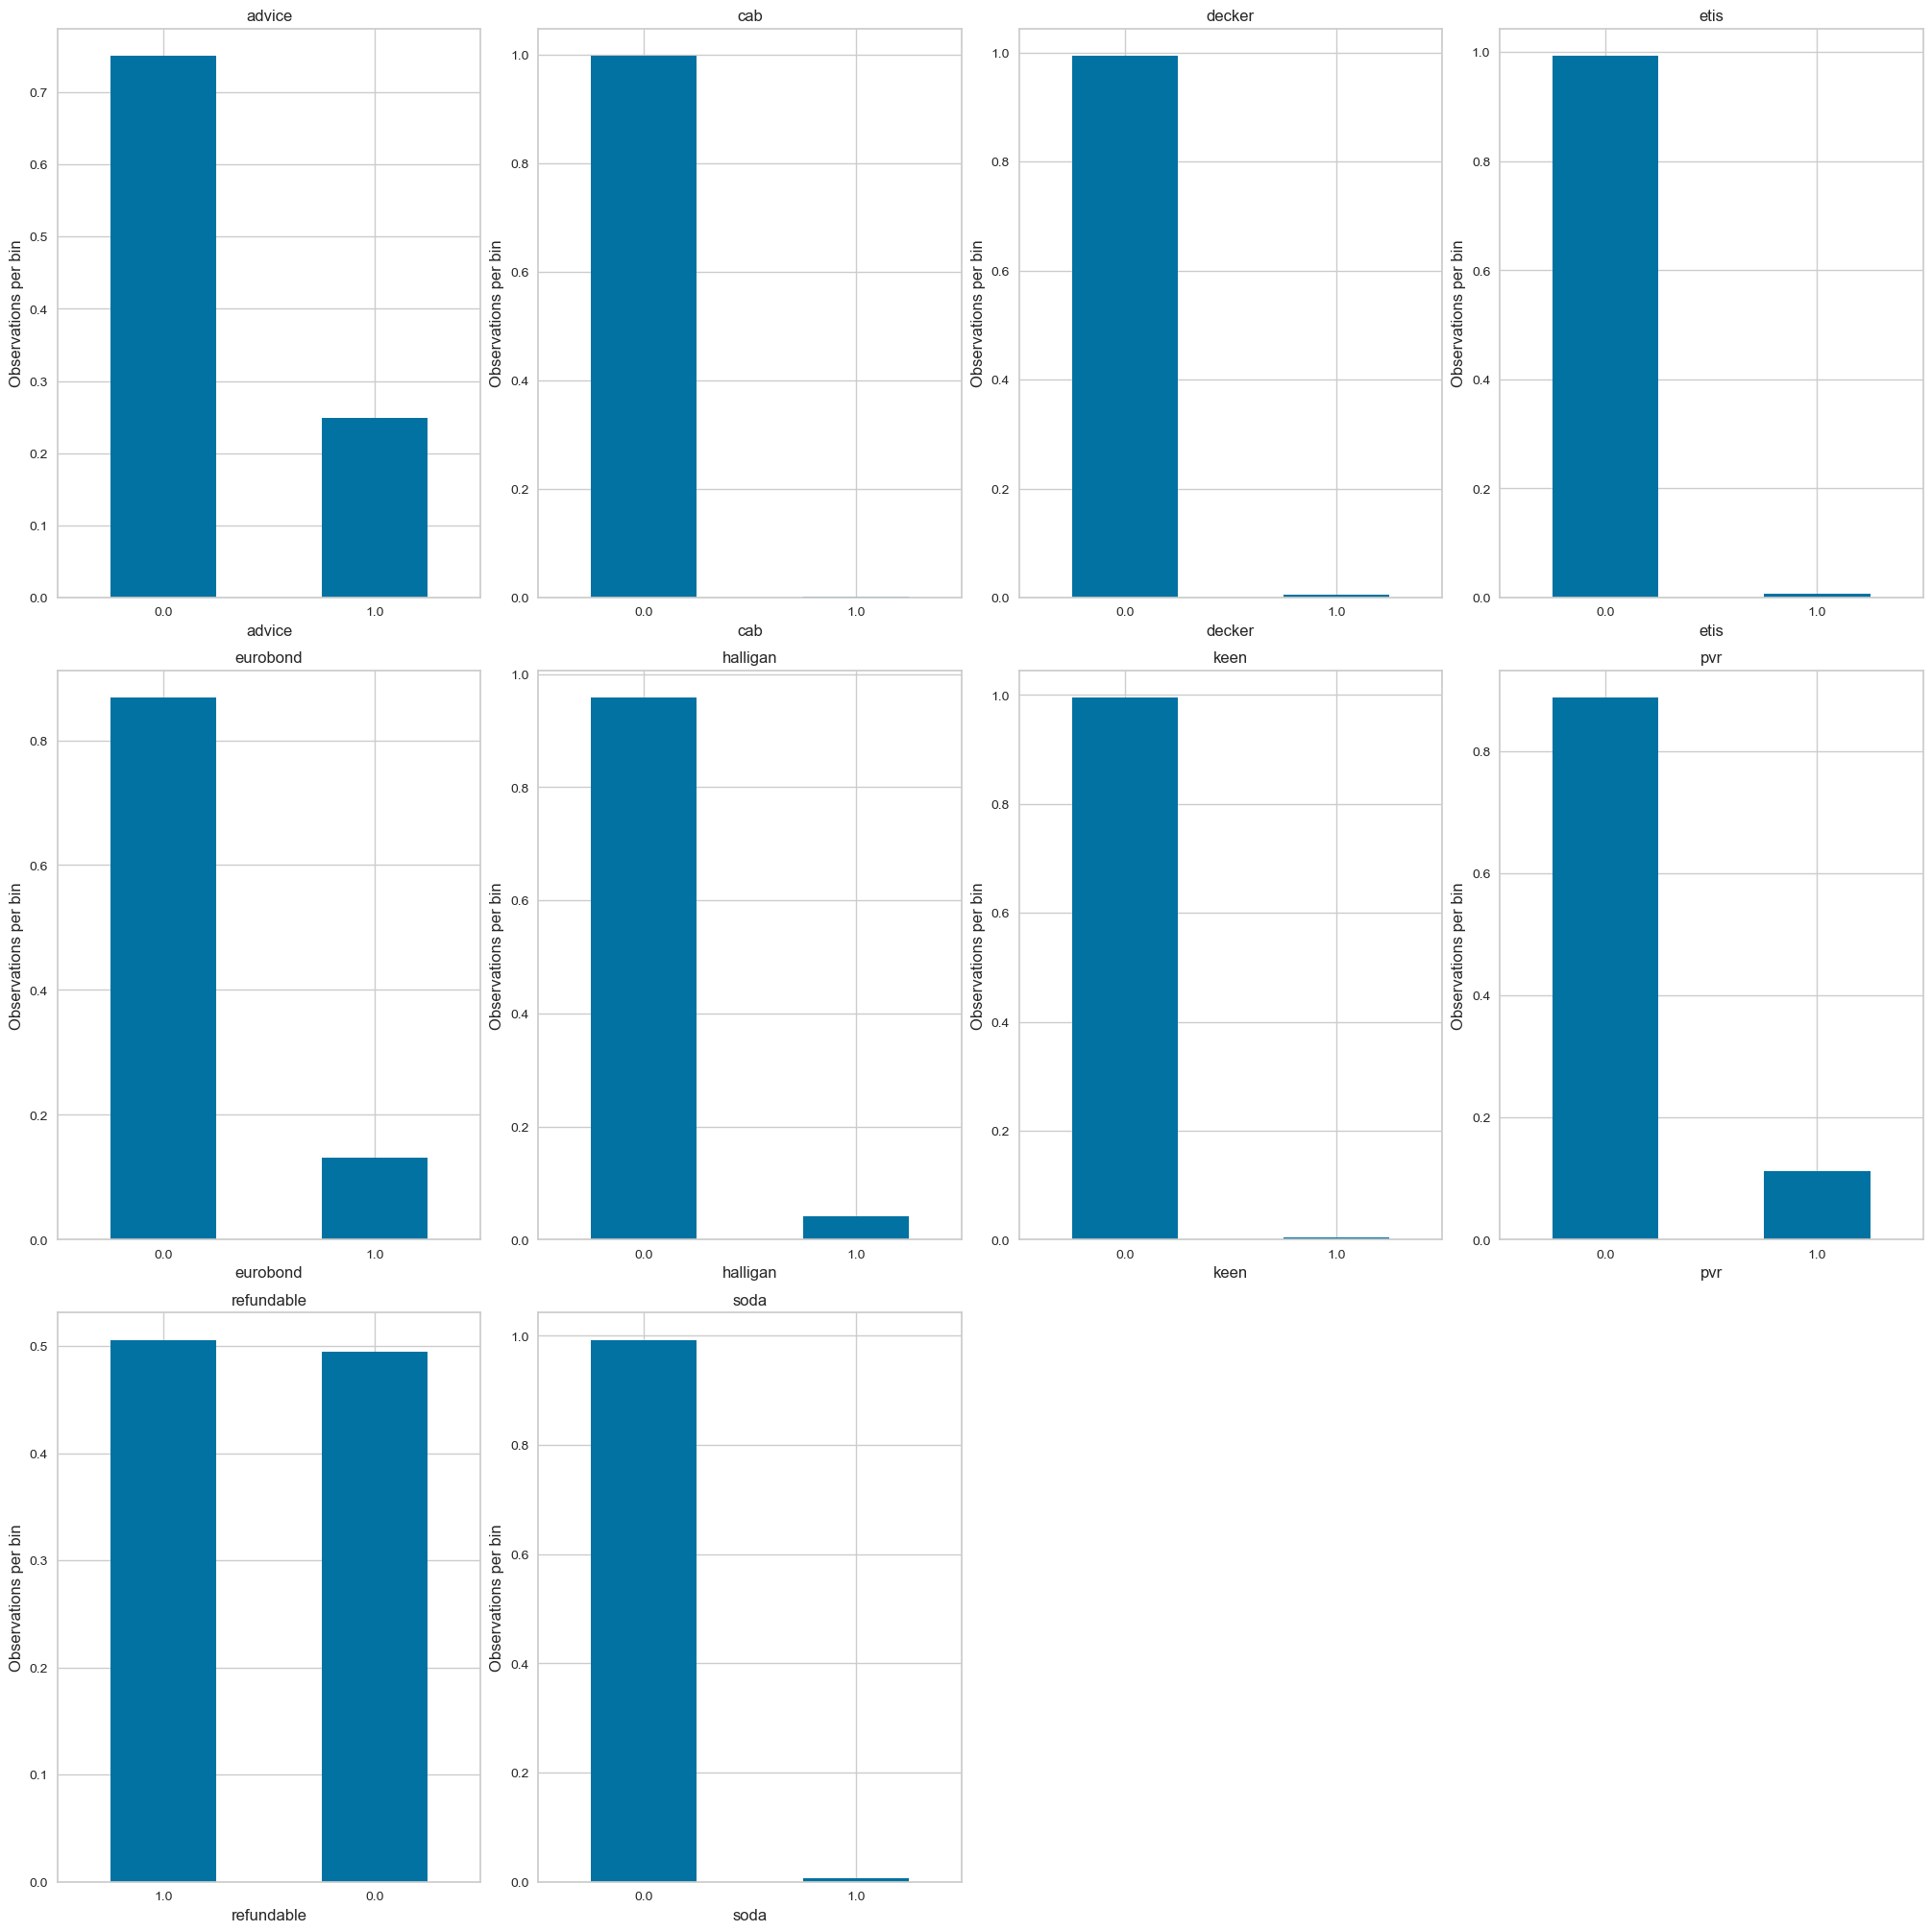

In [103]:
variables = data_t.columns.to_list()
plt.figure(figsize=(20, 20), constrained_layout=True)
for i in range(10):
    ax = plt.subplot(3, 4, i + 1)
    var = variables[i]
    t = data_t[var].value_counts(normalize=True)
    t.plot.bar(ax=ax)
    plt.xticks(rotation=0)
    plt.ylabel("Observations per bin")
    ax.set_title(var)
plt.show()

### Using decision trees for discretization

In all previous recipes in this chapter, we determined the number of intervals arbitrarily, and then the discretization algorithm would find the interval limits one way or another. Decision trees can find the interval limits and the optimal number of bins automaticallycopyright.

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from feature_engine.discretisation import DecisionTreeDiscretiser

X,y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

variables = list(X.columns)[:-2]
variables

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

Let's set up the transformer to discretize the variables from step 3. We want the transformer to optimize the hyperparameter's maximum depth and minimum samples per leaf of each tree based on the negative mean square error metric using three-fold cross-validation. As the output of the discretization, we want the limits of the intervals:

In [107]:
disc = DecisionTreeDiscretiser(
    bin_output='boundaries',
    precision=3,
    cv=3,
    scoring='neg_mean_squared_error',
    variables=variables,
    regression=True,
    param_grid={
        "max_depth": [1, 2, 3],
        "min_sample_leaf": [10, 20, 50]
    }
)

disc.fit(X_train, X_test)




ValueError: Found input variables with inconsistent numbers of samples: [14448, 6192]